#Final Assignment: Advanced Algorithms Design

Follow the example from Bootcamp 4 for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:

In [1]:
!pip install -U classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3

In [4]:
import classiq
classiq.authenticate()

/usr/local/lib/python3.10/dist-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [7]:
from classiq import *

###. Create a well-detailed Python Jupyter notebook that explains your algorithm, including the code parts covered in class, and pictures/figures where relevant.

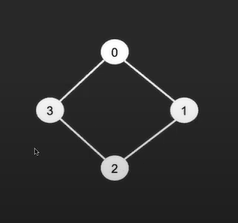

In class we see how to implement quantum walk operator for the case of a circle with 4 nodes, studying chaper 17 of Lecture Notes on Quantum Algorithms of
Andrew M. Childs from
Department of Computer Scienc chap 17 [https://www.cs.umd.edu/~amchilds/qa/qa.pdf]
from this lecture we can use this three formulas for implement our this algorithm





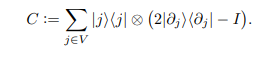 [1]

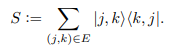[2]

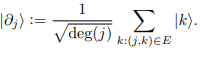 [3]

### For the case of [1], assuming that we know the unitary operation that represents 3 as described in the image below, we arrive at the fact that the right part of the tensor product is a familiar quantum primitive (PKB)!!!!
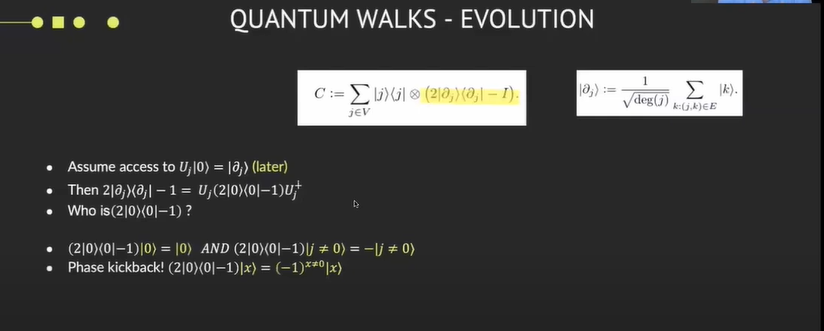

For the case covered in class we only use $n=size=2$  qubits for represent 4 nodes ($2 ^ n$)

In [5]:
size = 2

In [8]:
@qfunc
def prepare_minus(x: QBit): #prepare [-> state for pkb
  X(x)
  H(x)


In [9]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)  #operation for zero diffuzer


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux') #zero diffuser recieve X and
                    # initializes aux qubit
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


In [10]:
#for implement de summation we repeat over all iteration of the vertices so we use "repeat "function for this
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0]
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    #now we use "control "function this means only for desired state j> we apply the operator
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))



In [11]:
@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

### Our equation [2] directs us to have to implement an oracle that gives us the adjacency condition
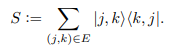[2]

In [12]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)

In [13]:
@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


In [14]:
@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

### Now putting everything together in a very organized way which gives an adequate visualization of the algorithm


In [15]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]
Opening: https://platform.classiq.io/circuit/be105d30-e58e-447b-a4fb-6a476fab1e83?version=0.43.3


### Now we design the quantum walk operator for the case of a line with 16 nodes:
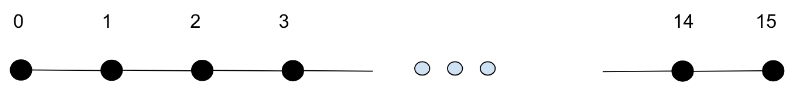

Its same thing for this case but our probabilites change for position of our walker, he only can move for the right or the left and in some cases only in one direction, this change our W operator changing amplitudes for probabilites of each state, for 16 nodes we use $n=4$

In [16]:
size= 4

In [17]:
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]* 2**size
    #prob[(i+1)% 4]=0.5
    #prob[(i-1)% 4]=0.5
    if i == 0:
        prob[i + 1] = 1.0  #first node [0] only 1 option  move to the right node
    elif i == (2**size) - 1:
        prob[i - 1] = 1.0  # If at the last node[15], only 1 optio move to the left node
    else: #for non-extreme nodes
        prob[i - 1] = 0.5
        prob[i + 1] = 0.5

    print(f'State={i}, prob vec ={prob}')
    #now we use "control "function this means only for desired state j> we apply the operator
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


In [18]:
@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

In [19]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
#  res |= (((vertices+adjacent_vertices)%2) ==1)

  res |= ((vertices - adjacent_vertices) == 1)
  res |= ((vertices - adjacent_vertices) == -1)


In [20]:
#bitwise swap doesnt change
@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


In [21]:
@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

In [22]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

ClassiqAPIError: 
	Trying to access handle 'res' as output but it is in incorrect state
		at file <ipython-input-19-0584d9917648> line 6

Error identifier: EDE65C3F8-1324-4805-A882-35407271BF82.
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack